In [1]:
# import libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

%matplotlib inline

# read in the dataset

df = pd.read_csv('../data/cleaned/final.csv')

In [2]:
df.head()

subreddit             author        date  \
0  alcoholism    glorybellpirate  2020-01-01   
1  alcoholism      EhndlessSl0th  2020-01-01   
2  alcoholism  the_kinky_penguin  2020-01-01   
3  alcoholism    SauceoffSauceOn  2020-01-01   
4  alcoholism           ben42187  2020-01-01   

                                                post  covid_related  suicidal  \
0  Day 1 of sobriety Feeling anxious and letting ...              0         0   
1  Started the New Year with a bang. Hey, I'm new...              0         1   
2  Why can't I get drunk anymore I've been a heav...              0         0   
3  I am an Alcoholic. How do I quit? I have been ...              0         0   
4  Funniest Thing about Alcoholism With every oth...              0         0   

   alc_abuse  loneliness  stress  n_words  n_sentences  \
0          1           0       0       24            3   
1          1           0       1      577           41   
2          1           0       0       64            5   
3          1           0       1      111           14   
4          1           0       0      136            9   

                                          lemmatized  
0  day 1 of sobriety feel anxious and let the fee...  
1  start the new year with a bang hey -pron- be n...  
2  why ca not -pron- get drunk anymore -pron- hav...  
3  -pron- be an alcoholic how do -pron- quit -pro...  
4  funniest thing about alcoholism with every oth...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102031 entries, 0 to 102030
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   subreddit      102031 non-null  object
 1   author         102031 non-null  object
 2   date           102031 non-null  object
 3   post           102031 non-null  object
 4   covid_related  102031 non-null  int64 
 5   suicidal       102031 non-null  int64 
 6   alc_abuse      102031 non-null  int64 
 7   loneliness     102031 non-null  int64 
 8   stress         102031 non-null  int64 
 9   n_words        102031 non-null  int64 
 10  n_sentences    102031 non-null  int64 
 11  lemmatized     102031 non-null  object
dtypes: int64(7), object(5)
memory usage: 9.3+ MB


In [4]:
# reformat date column to date field

df['date'] = pd.to_datetime(df['date'])

In [5]:
# check the subreddits

df['subreddit'].unique()

array(['alcoholism', 'suicidewatch', 'mentalhealth', 'lonely',
       'healthanxiety', 'depression', 'bipolarreddit', 'anxiety'],
      dtype=object)

In [6]:
# check the first date of last date of collection

print(df['date'].min())
print(df['date'].max())

2020-01-01 00:00:00
2020-04-20 00:00:00


In [7]:
# check numeric fields

df.describe()

covid_related       suicidal      alc_abuse     loneliness  \
count  102031.000000  102031.000000  102031.000000  102031.000000   
mean        0.113368       0.251110       0.177593       0.280728   
std         0.317043       0.433654       0.382172       0.449357   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       1.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

              stress        n_words    n_sentences  
count  102031.000000  102031.000000  102031.000000  
mean        0.287814     208.572718      15.218894  
std         0.452746     213.332393      14.809752  
min         0.000000       2.000000       1.000000  
25%         0.000000      80.000000       6.000000  
50%         0.000000     148.000000      11.000000  
75%         1.000000     264.000000      19.000000  
max         1.000000    5854.000000     481.000000

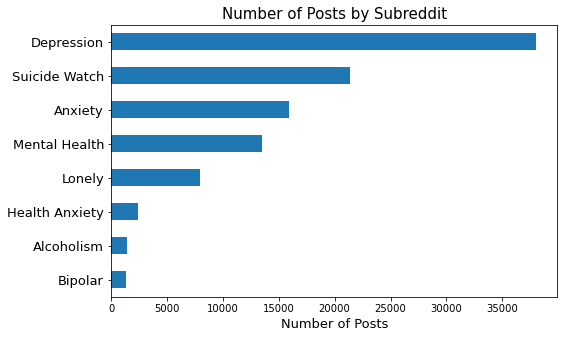

In [8]:
# plot the number of posts by each subreddit

plt.figure(figsize = (8, 5))
df['subreddit'].value_counts().sort_values(ascending = True).plot(kind = 'barh')
plt.yticks(size = 13, 
           ticks = list(range(8)),
           labels = ['Bipolar', 'Alcoholism', 'Health Anxiety', 'Lonely', 'Mental Health', 'Anxiety', 'Suicide Watch', 'Depression'])
plt.xlabel('Number of Posts', size = 13)
plt.title('Number of Posts by Subreddit', size = 15)
plt.savefig('../images/num_posts_subreddit.png');

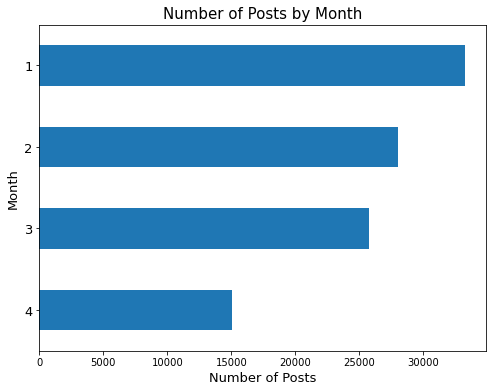

In [9]:
# plot the number of posts by each date

plt.figure(figsize = (8, 6))

# remove timestamp and count the number of posts, then plot

pd.to_datetime(df['date']).dt.month.value_counts().sort_index(ascending = False).plot(kind = 'barh')

plt.yticks(size = 13)

plt.xlabel('Number of Posts', size = 13)
plt.ylabel('Month', size = 13)

plt.title('Number of Posts by Month', size = 15)

plt.savefig('../images/num_posts_month.png');

In [10]:
# calculate the percentage for number of posts for each subreddit

monthly = pd.DataFrame(df.groupby(df['date'].dt.month)['subreddit'].value_counts(normalize = True))

In [11]:
monthly.index[:5]

MultiIndex([(1,   'depression'),
            (1, 'suicidewatch'),
            (1,      'anxiety'),
            (1, 'mentalhealth'),
            (1,       'lonely')],
           names=['date', 'subreddit'])

In [12]:
# monthly index is multi-index -> unpack -> store values in the dataframe

month = []
sub = []

for i in range(len(monthly.index)):
    
    (m, s) = monthly.index[i]
    month.append(m)
    sub.append(s)
    
monthly['month'] = month
monthly['sub'] = sub

In [13]:
monthly[:5]

subreddit  month           sub
date subreddit                                   
1    depression     0.403172      1    depression
     suicidewatch   0.193896      1  suicidewatch
     anxiety        0.152360      1       anxiety
     mentalhealth   0.122893      1  mentalhealth
     lonely         0.073802      1        lonely

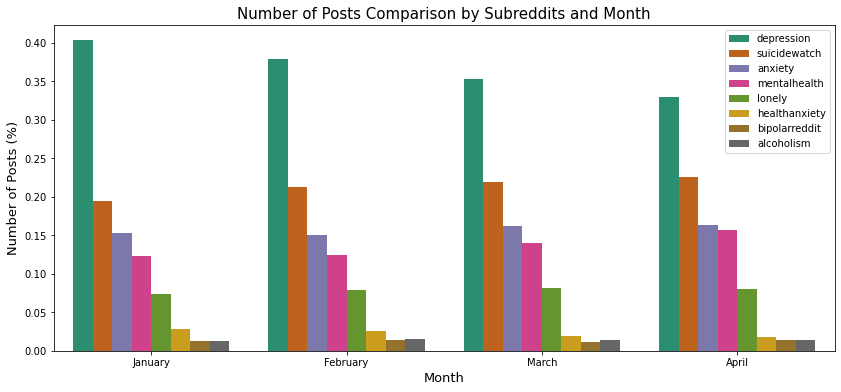

In [14]:
# plot monthly

plt.figure(figsize = (14, 6))

sns.barplot(x = 'month', y = 'subreddit', data = monthly, 
            hue = 'sub', palette = 'Dark2')
#sns.lineplot(x = 'month', y = 'subreddit', data = monthly[monthly['sub'] == 'suicidewatch'], markers = True)
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend()
plt.title('Number of Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/pct_category_month.png');

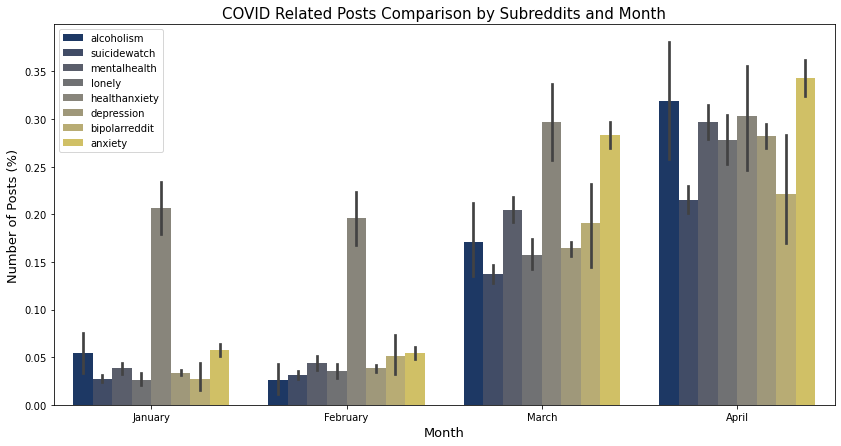

In [15]:
# plot covid related posts

plt.figure(figsize = (14, 7))

sns.barplot(x = df['date'].dt.month, y = 'covid_related', hue = 'subreddit', 
            data = df, palette = 'cividis')
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend()
plt.title('COVID Related Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/covid_comparison.png');

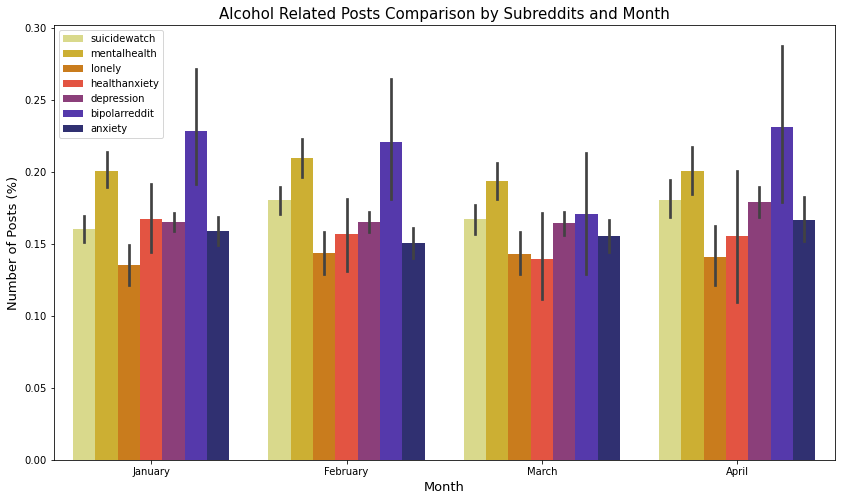

In [16]:
# plot alcohol abuse related posts

plt.figure(figsize = (14, 8))

sns.barplot(x = df['date'].dt.month, y = 'alc_abuse', hue = 'subreddit', 
            data = df[df['subreddit'] != 'alcoholism'], palette = 'CMRmap_r')
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend(loc = 'best')
plt.title('Alcohol Related Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/alcohol_comparison.png');

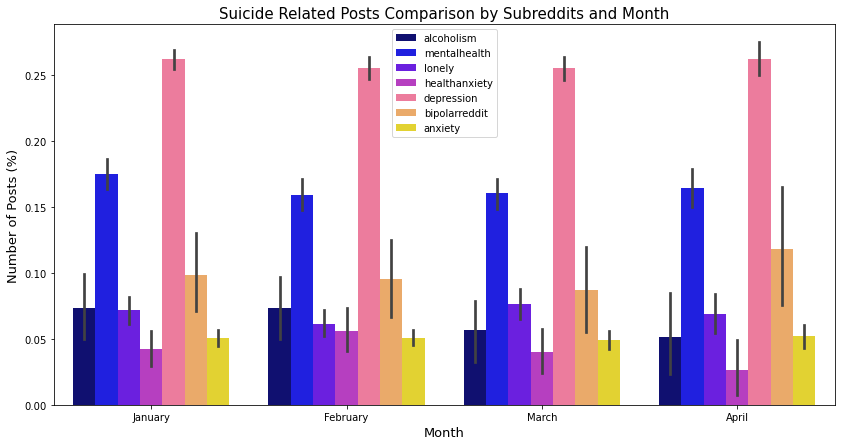

In [31]:
# plot suicide related posts

plt.figure(figsize = (14, 7))

sns.barplot(x = df['date'].dt.month, y = 'suicidal', hue = 'subreddit', 
            data = df[df['subreddit'] != 'suicidewatch'], palette = 'gnuplot2')
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend(loc = 'best')
plt.title('Suicide Related Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/suicide_comparison.png');

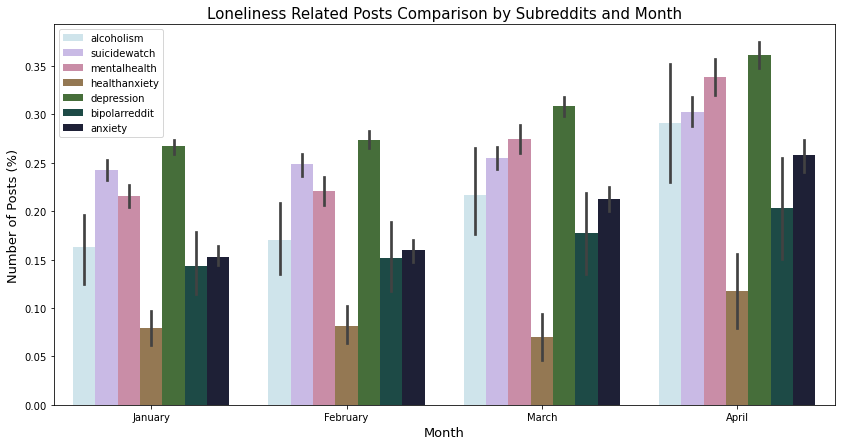

In [18]:
# plot loneliness related posts

plt.figure(figsize = (14, 7))

sns.barplot(x = df['date'].dt.month, y = 'loneliness', hue = 'subreddit', 
            data = df[df['subreddit'] != 'lonely'], palette = 'cubehelix_r')
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend(loc = 'best')
plt.title('Loneliness Related Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/lonely_comparison.png');

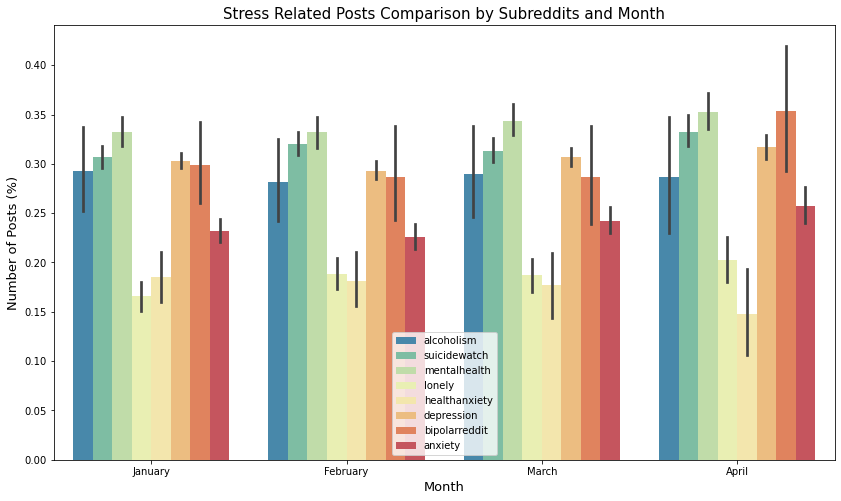

In [19]:
# plot stress related posts

plt.figure(figsize = (14, 8))

sns.barplot(x = df['date'].dt.month, y = 'stress', hue = 'subreddit', 
            data = df, palette = 'Spectral_r')
plt.xlabel('Month', size = 13)
plt.ylabel('Number of Posts (%)', size = 13)
plt.xticks([0, 1, 2, 3], ['January', 'February', 'March', 'April'])
plt.legend(loc = 'best')
plt.title('Stress Related Posts Comparison by Subreddits and Month', size = 15)
plt.savefig('../images/stress_comparison.png');

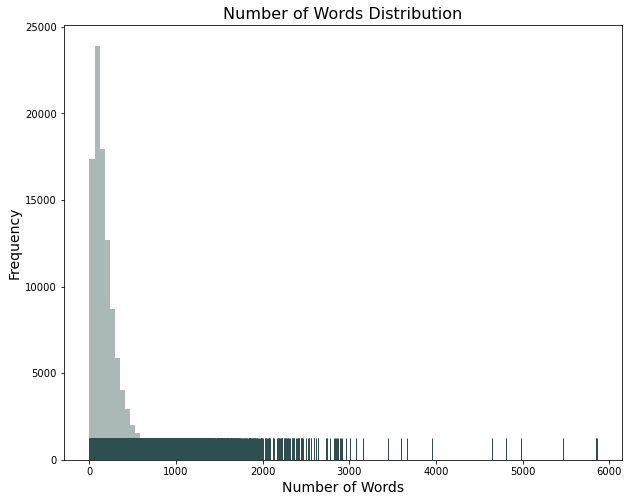

In [20]:
# distribution: number of words

plt.figure(figsize = (10, 8))

sns.distplot(df['n_words'], bins = 100, rug = True, color = 'darkslategray', kde = False)

plt.xlabel('Number of Words', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title('Number of Words Distribution', size = 16)
plt.savefig('../images/words_dist.png')

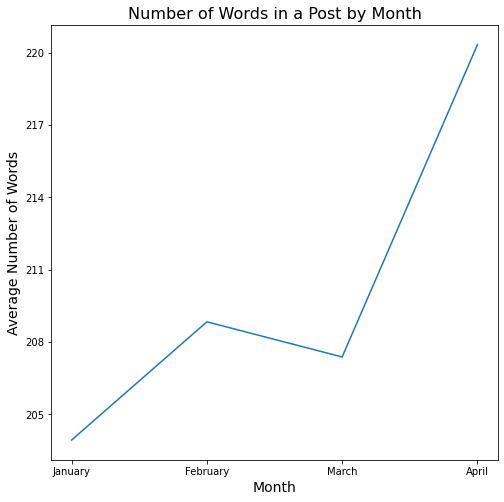

In [21]:
# number of words by month

plt.figure(figsize = (8, 8))

df.groupby(df['date'].dt.month)['n_words'].mean().plot()
plt.xticks(ticks = [1, 2, 3, 4], labels = ['January', 'February', 'March', 'April'])
plt.yticks(ticks = list(range(205, 221, 3)))
plt.xlabel('Month', size = 14)
plt.ylabel('Average Number of Words', size = 14)
plt.title('Number of Words in a Post by Month', size = 16)
plt.savefig('../images/n_words_month.png');

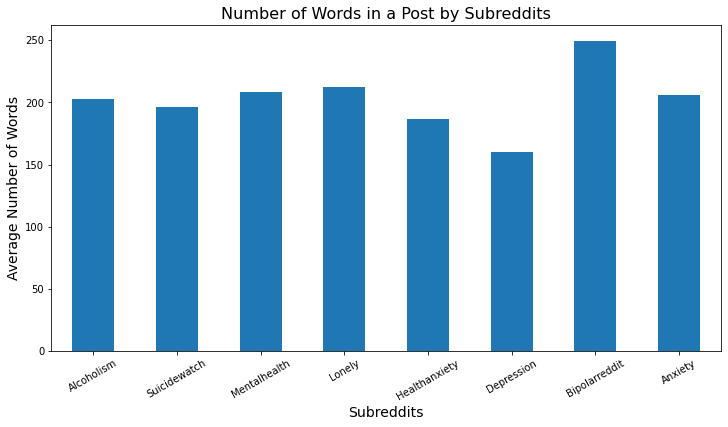

In [22]:
# number of words by subreddit

plt.figure(figsize = (12, 6))

df.groupby('subreddit')['n_words'].mean().plot(kind = 'bar')
plt.xticks(ticks = list(range(8)), labels = [sub.title() for sub in df['subreddit'].unique()], rotation = 30)
plt.xlabel('Subreddits', size = 14)
plt.ylabel('Average Number of Words', size = 14)
plt.title('Number of Words in a Post by Subreddits', size = 16)
plt.savefig('../images/n_words_reddits.png');

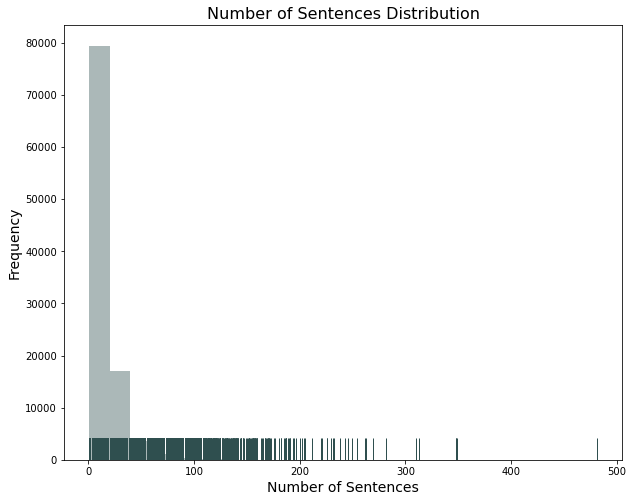

In [23]:
# distribution: number of sentences

plt.figure(figsize = (10, 8))

sns.distplot(df['n_sentences'], bins = 25, rug = True, color = 'darkslategray', kde = False)

plt.xlabel('Number of Sentences', size = 14)
plt.ylabel('Frequency', size = 14)
plt.title('Number of Sentences Distribution', size = 16)
plt.savefig('../images/sents_dist.png')

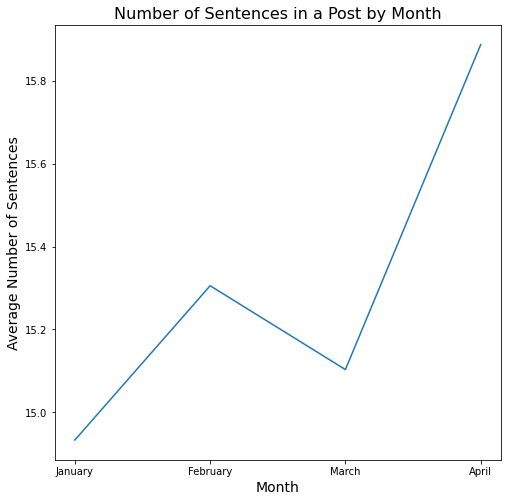

In [24]:
# number of sentences by month

plt.figure(figsize = (8, 8))

df.groupby(df['date'].dt.month)['n_sentences'].mean().plot()
plt.xticks(ticks = [1, 2, 3, 4], labels = ['January', 'February', 'March', 'April'])
plt.xlabel('Month', size = 14)
plt.ylabel('Average Number of Sentences', size = 14)
plt.title('Number of Sentences in a Post by Month', size = 16)
plt.savefig('../images/n_sents_month.png');

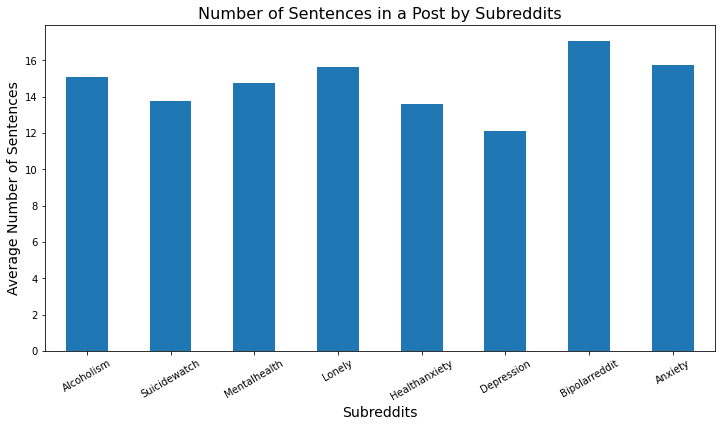

In [25]:
# number of words by subreddit

plt.figure(figsize = (12, 6))

df.groupby('subreddit')['n_sentences'].mean().plot(kind = 'bar')
plt.xticks(ticks = list(range(8)), labels = [sub.title() for sub in df['subreddit'].unique()], rotation = 30)
plt.xlabel('Subreddits', size = 14)
plt.ylabel('Average Number of Sentences', size = 14)
plt.title('Number of Sentences in a Post by Subreddits', size = 16)
plt.savefig('../images/n_sents_reddits.png');

In [26]:
## Wordcloud with stopwords

# update wordcloud stopwords

custom_stop = {'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 'pron', 'don', 'will'}

stop = STOPWORDS.union(custom_stop)

In [27]:
# create a function to generate wordcloud plots repeatedly

def wordcloud(image, data, background, color, title, save_name, font, fig):

    mask = np.array(Image.open(f'../images/assets/{image}'))
    txt = ' '.join(data)

    img_color = ImageColorGenerator(mask)

    wc = WordCloud(mask = mask, max_words = 4000, stopwords = stop, colormap = color, max_font_size = font,
               background_color = background, random_state = 42).generate(txt)

    plt.figure(figsize = fig)

    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis('off')
    
    plt.title(title, size = 25)

    plt.savefig(f'../images/{save_name}.png');

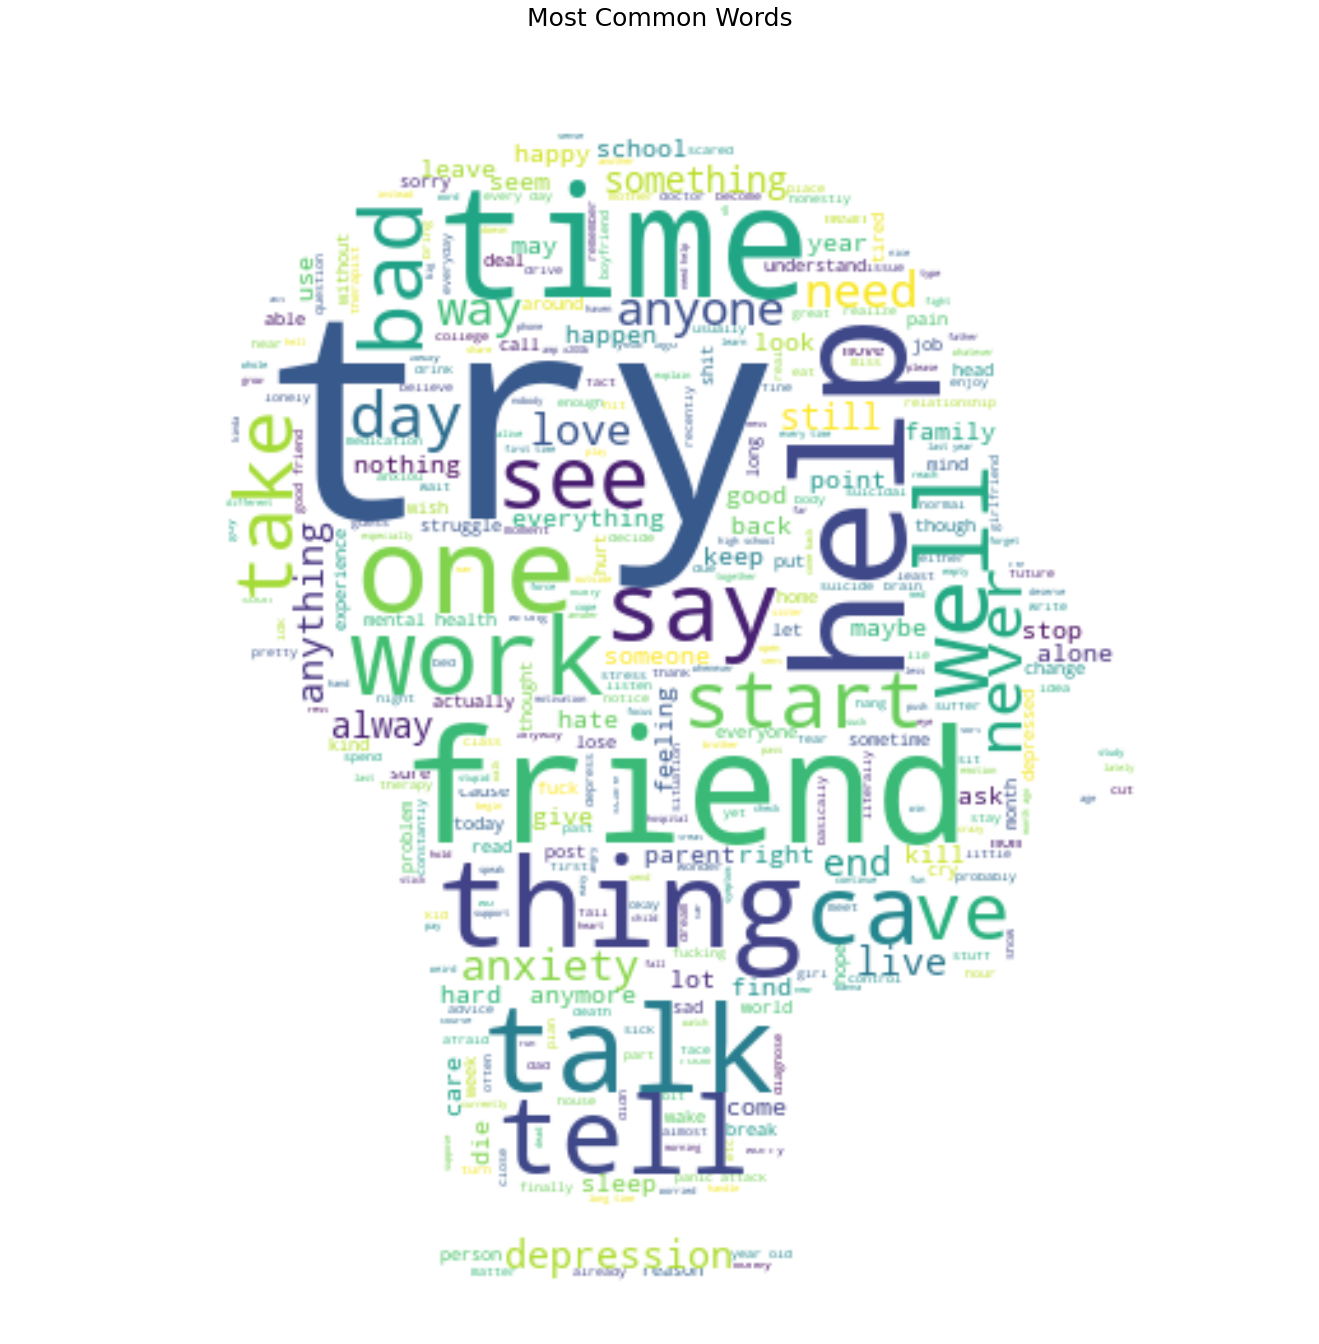

In [28]:
# wordcloud for entire dataset

wordcloud(image = 'head.jpg', data = df['lemmatized'], color = 'viridis', font = 120, fig = (24, 24),
          title = 'Most Common Words', save_name = 'wc_whole', background = 'white')

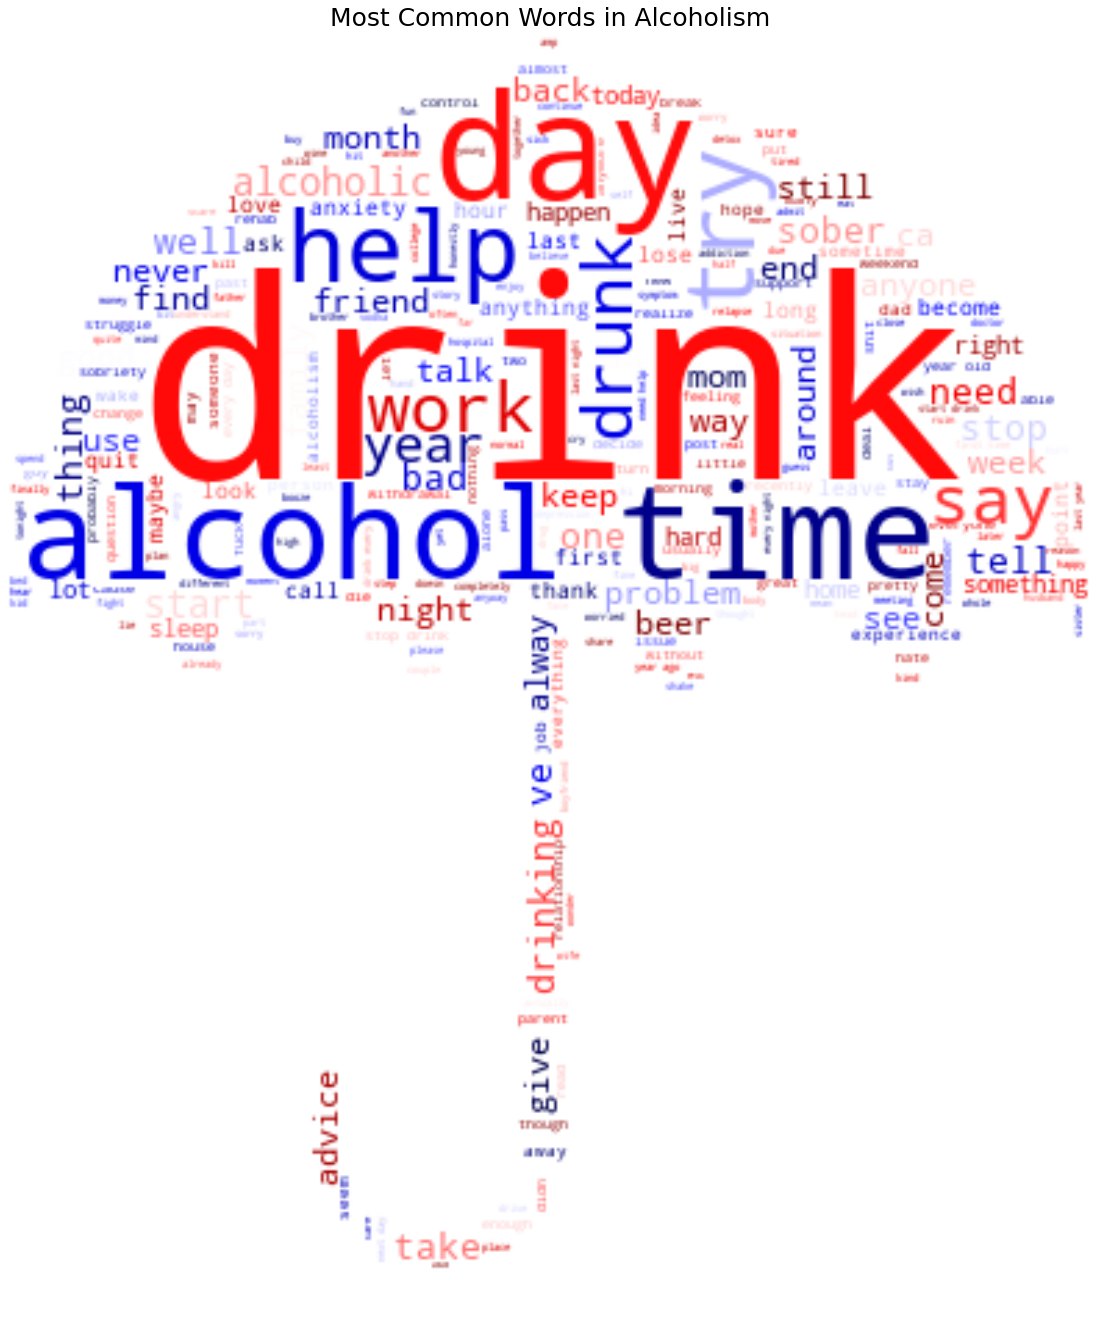

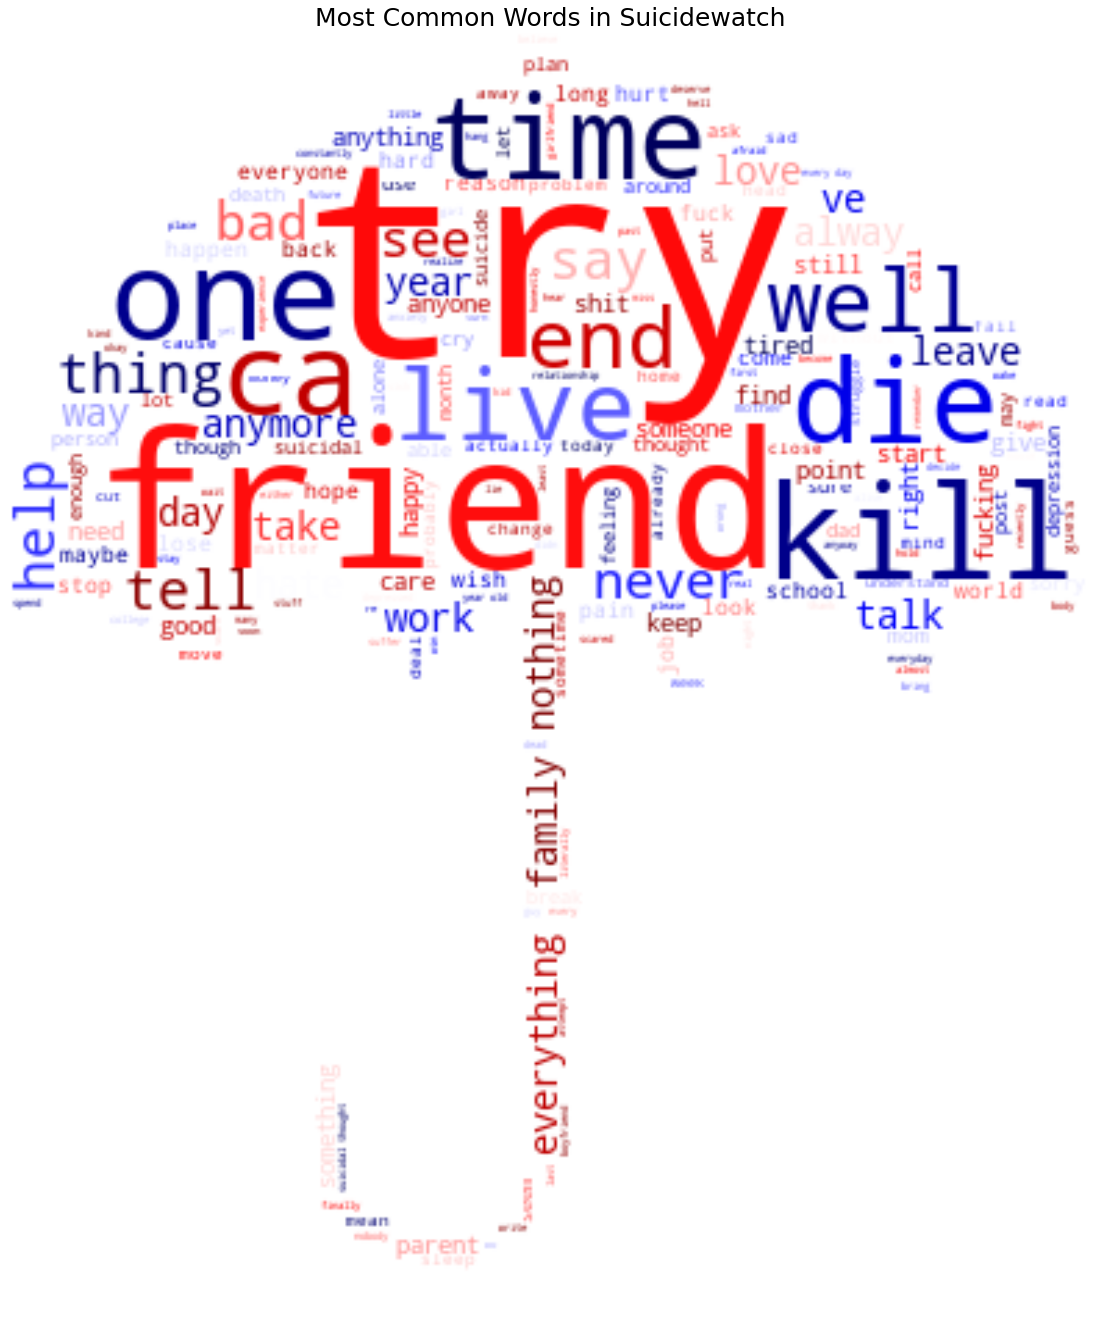

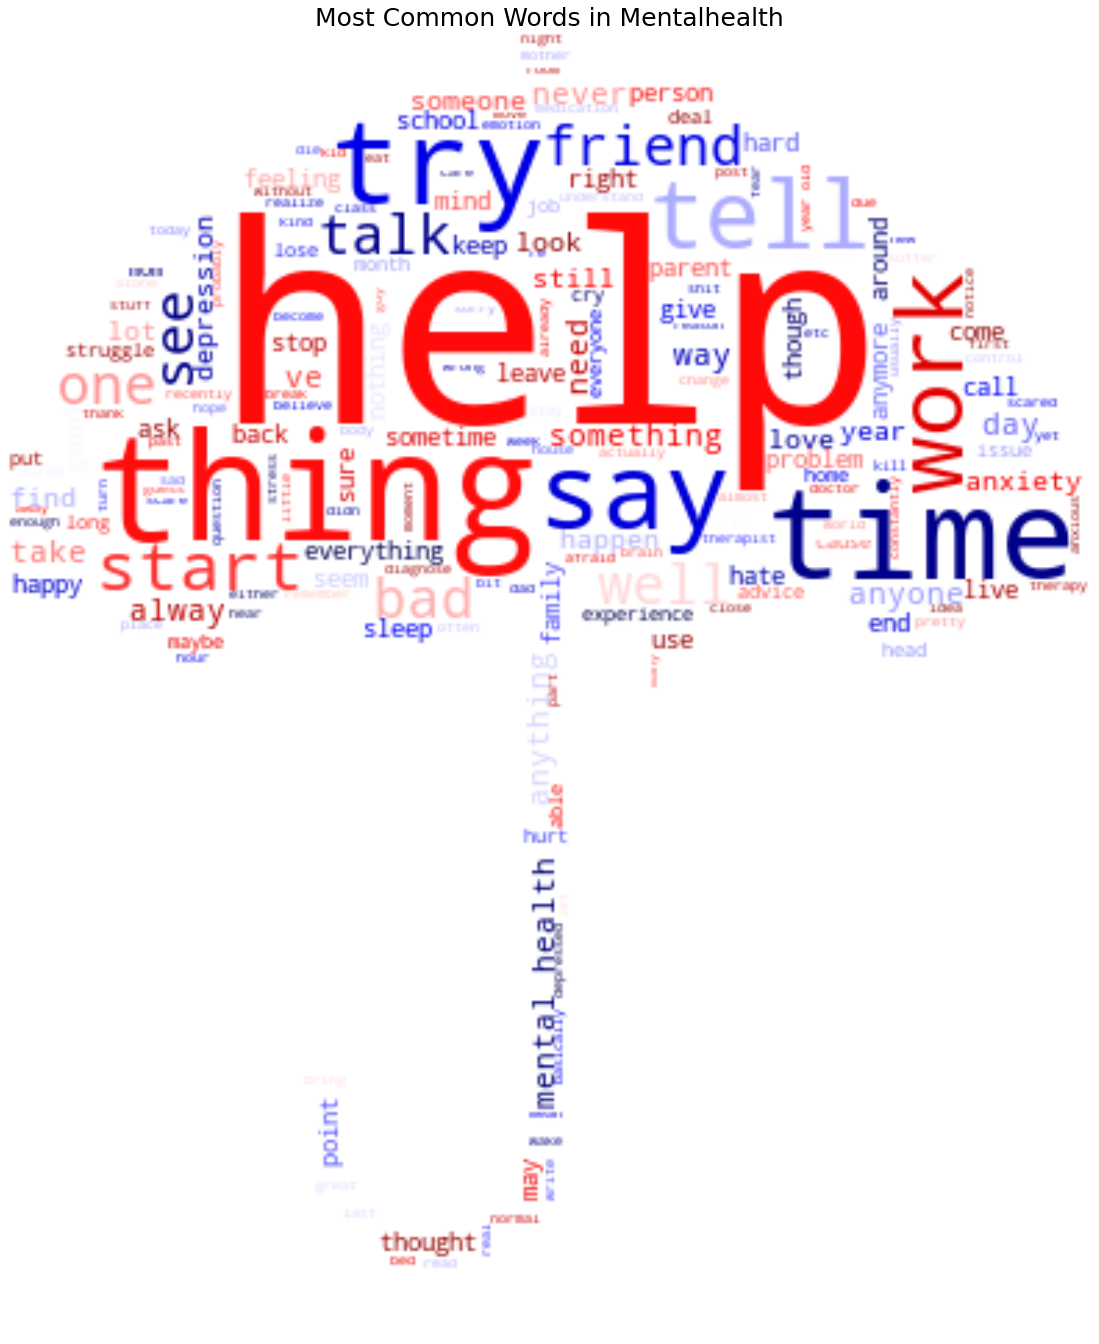

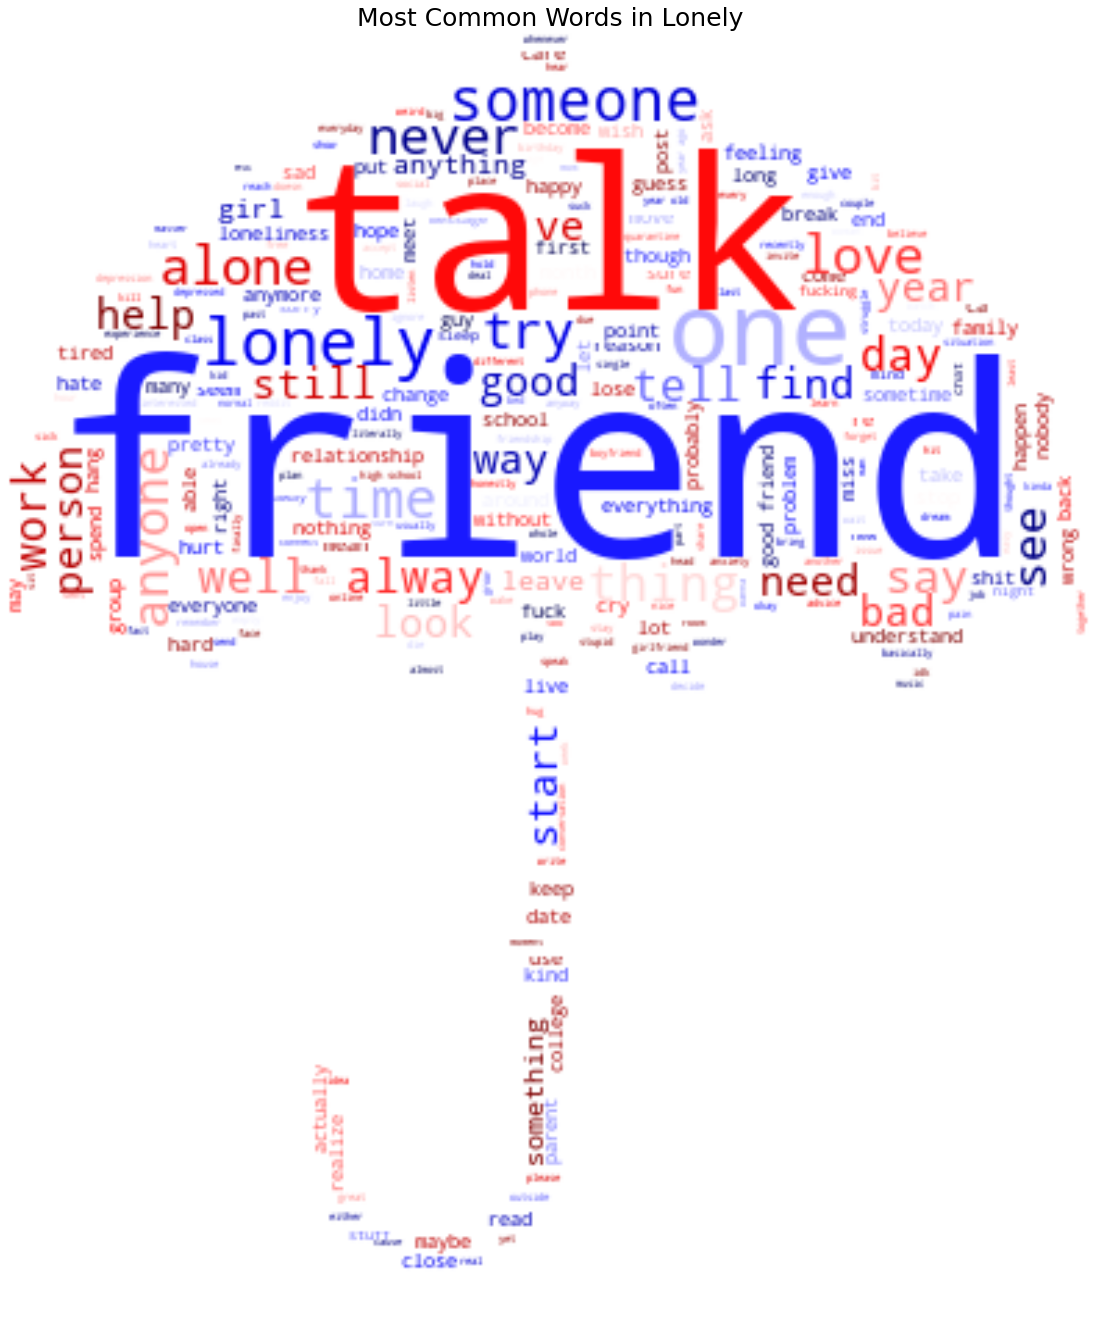

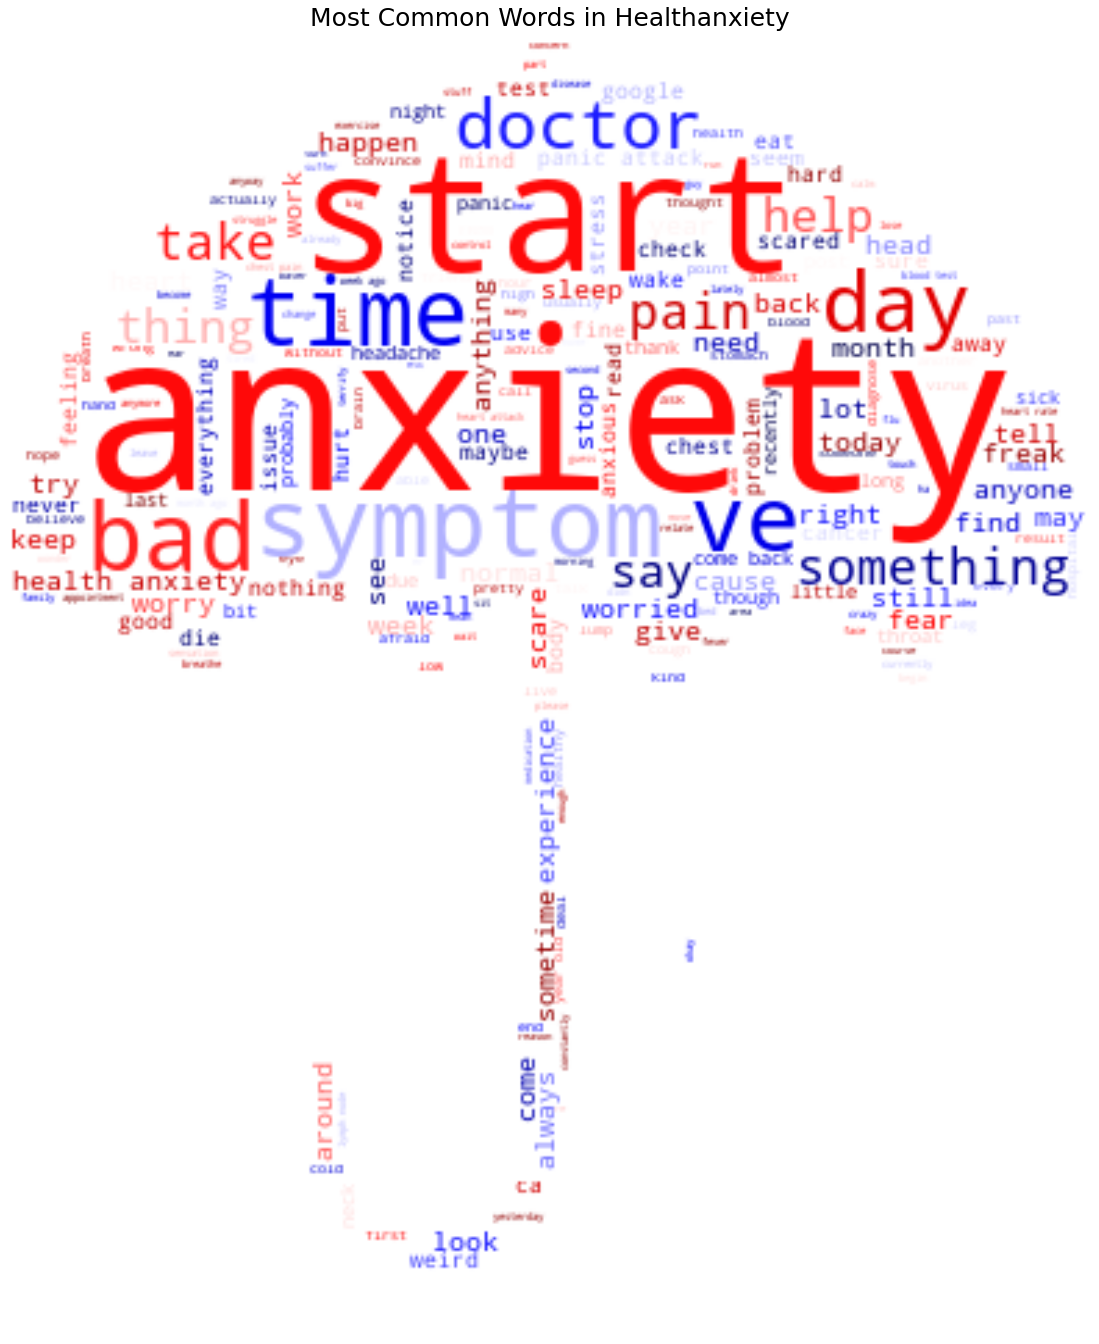

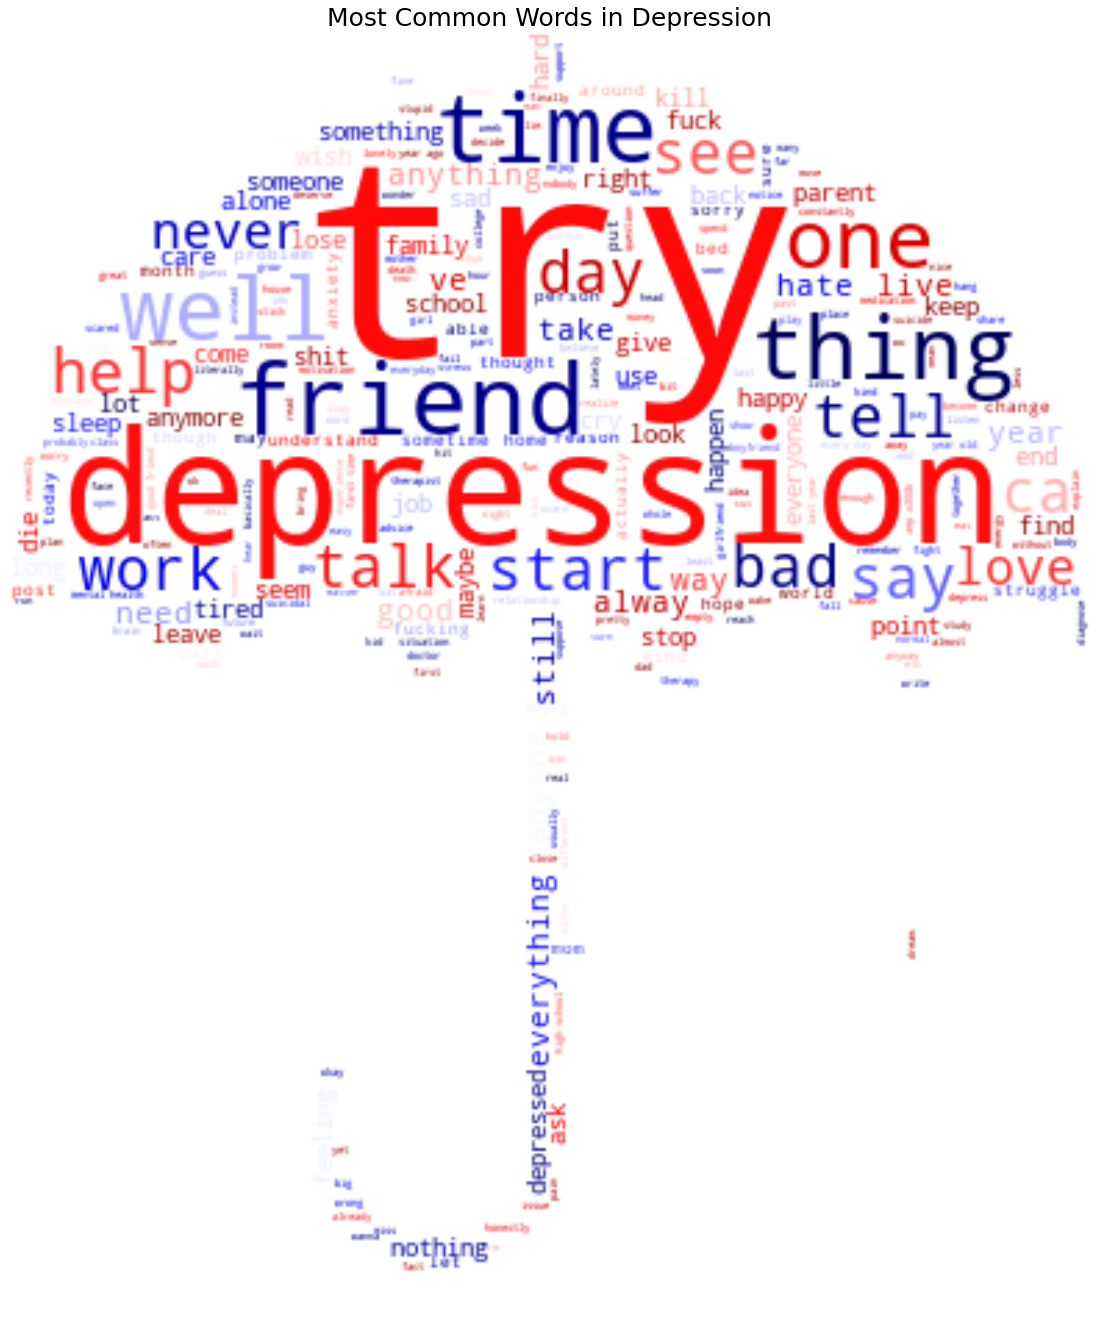

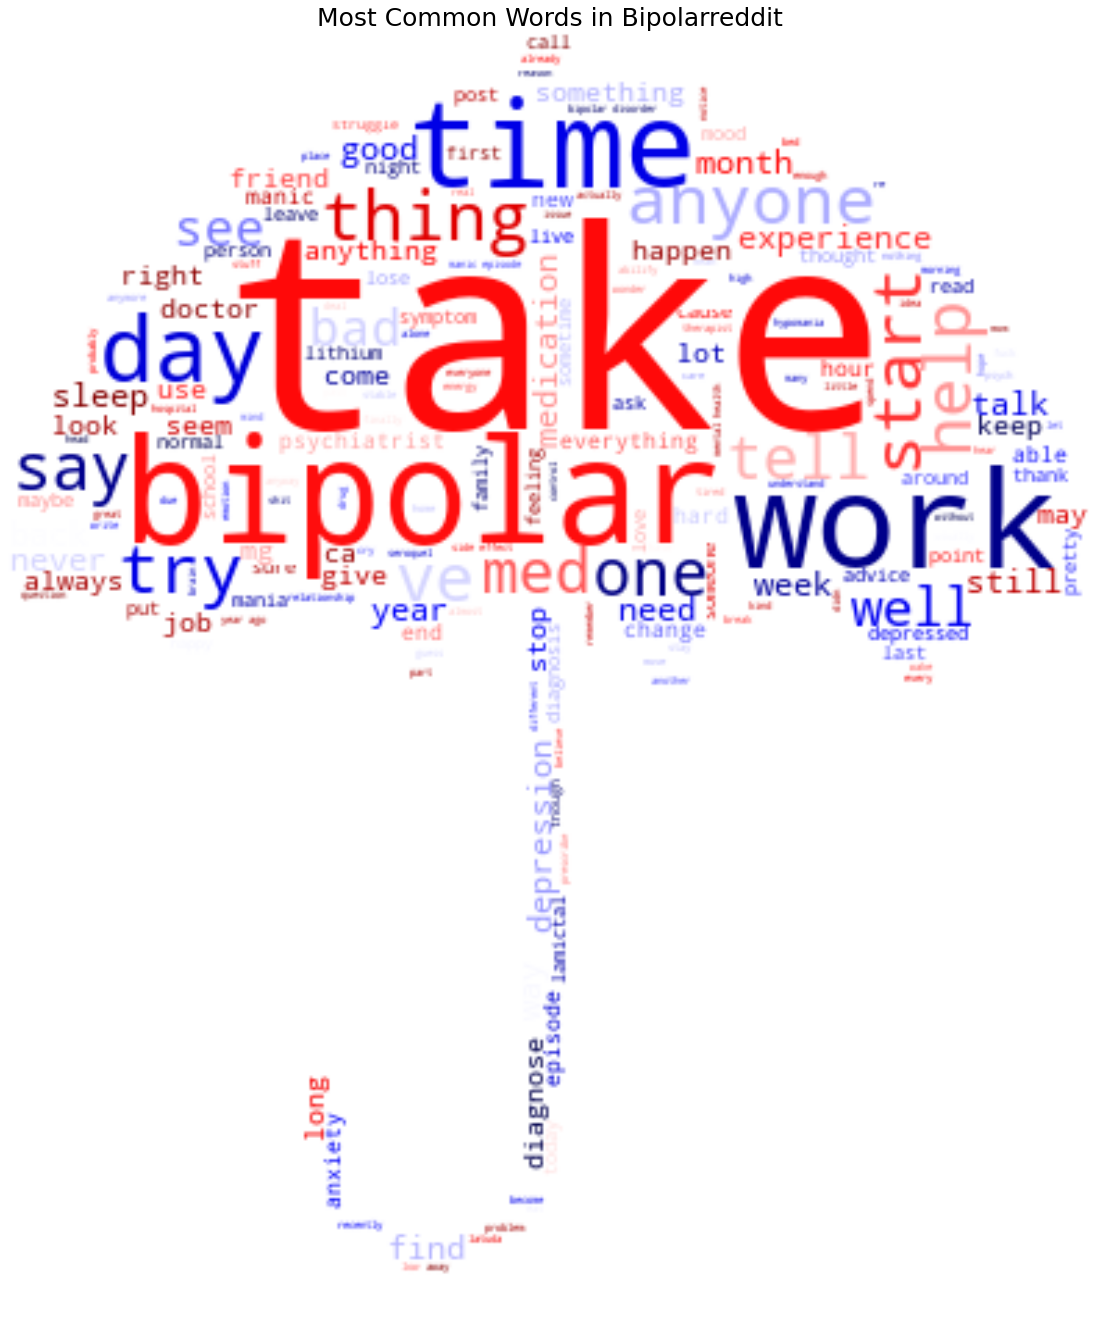

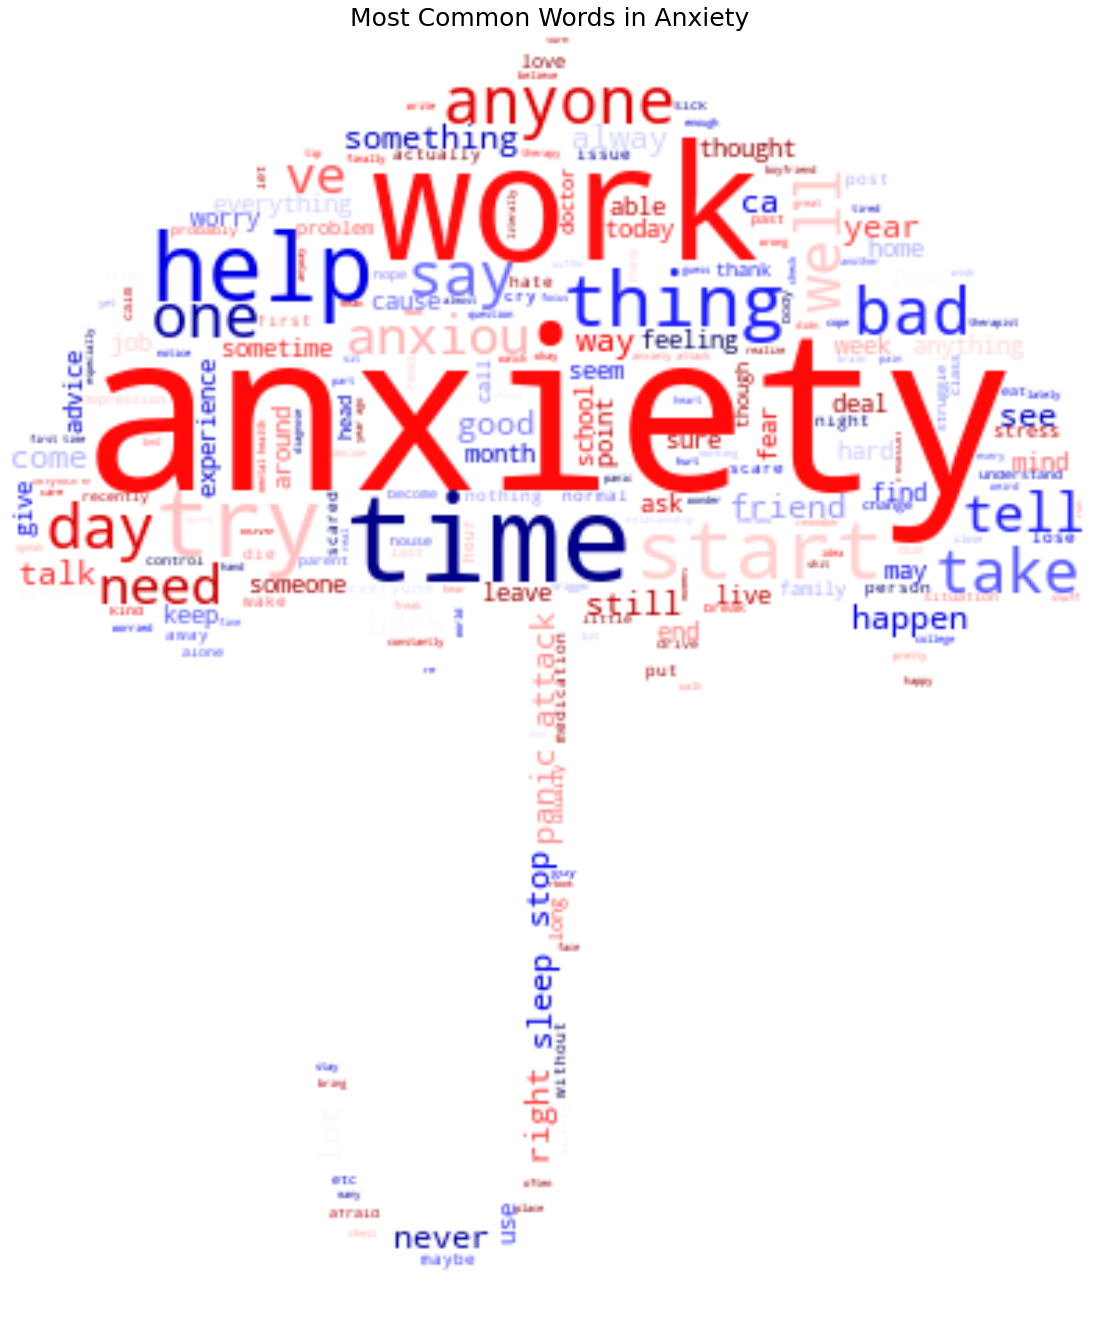

In [29]:
# wordcloud for subreddits

subreddits = df['subreddit'].unique()

for sub in subreddits:
    
    wordcloud(image = 'umbrella.jpg', data = df[df['subreddit'] == sub ]['lemmatized'], color = 'seismic', font = 100,
              fig = (24, 24), title = f'Most Common Words in {sub.title()}', save_name = f'wc_{sub}', background = 'white')

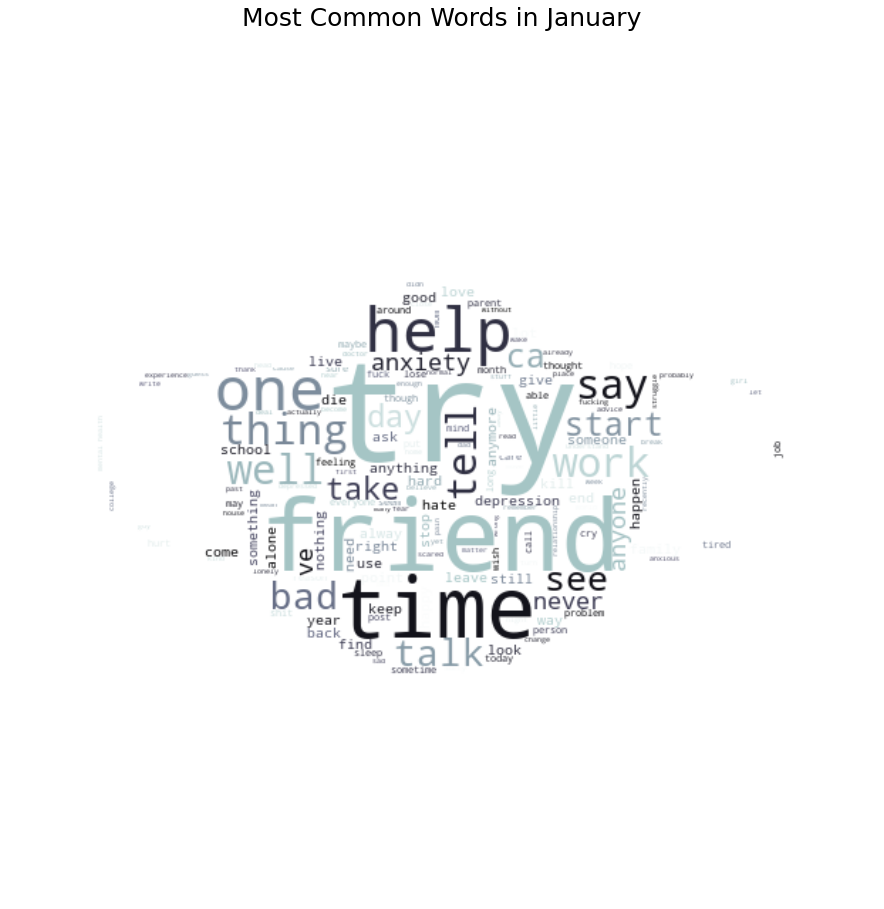

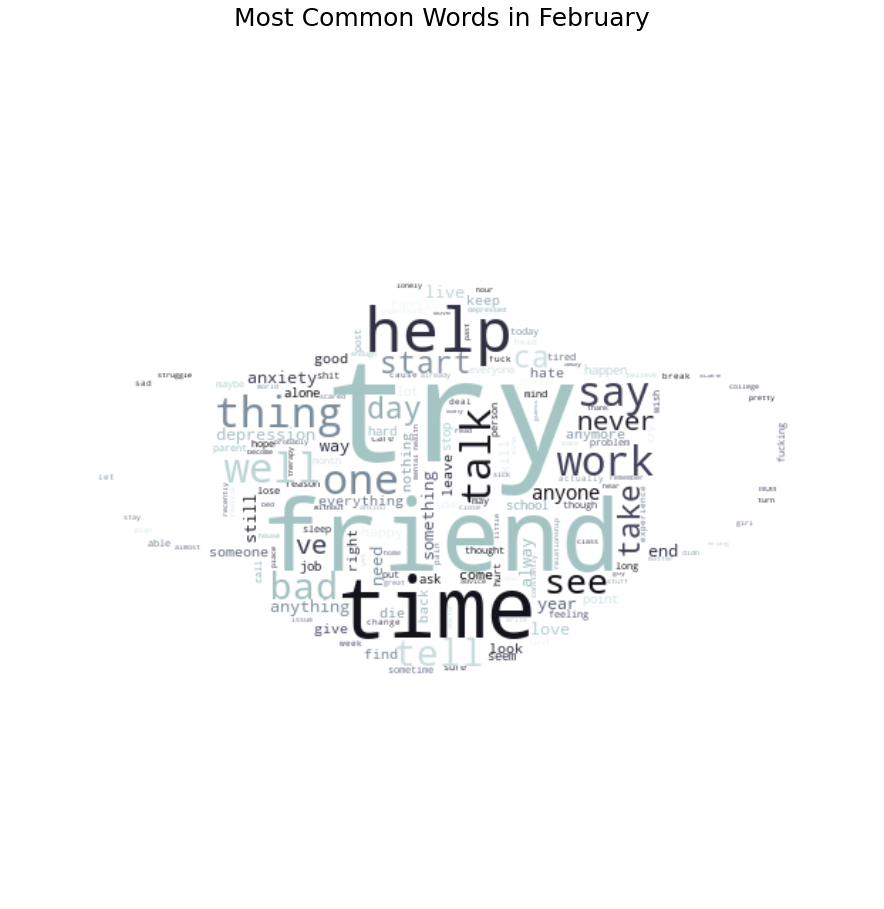

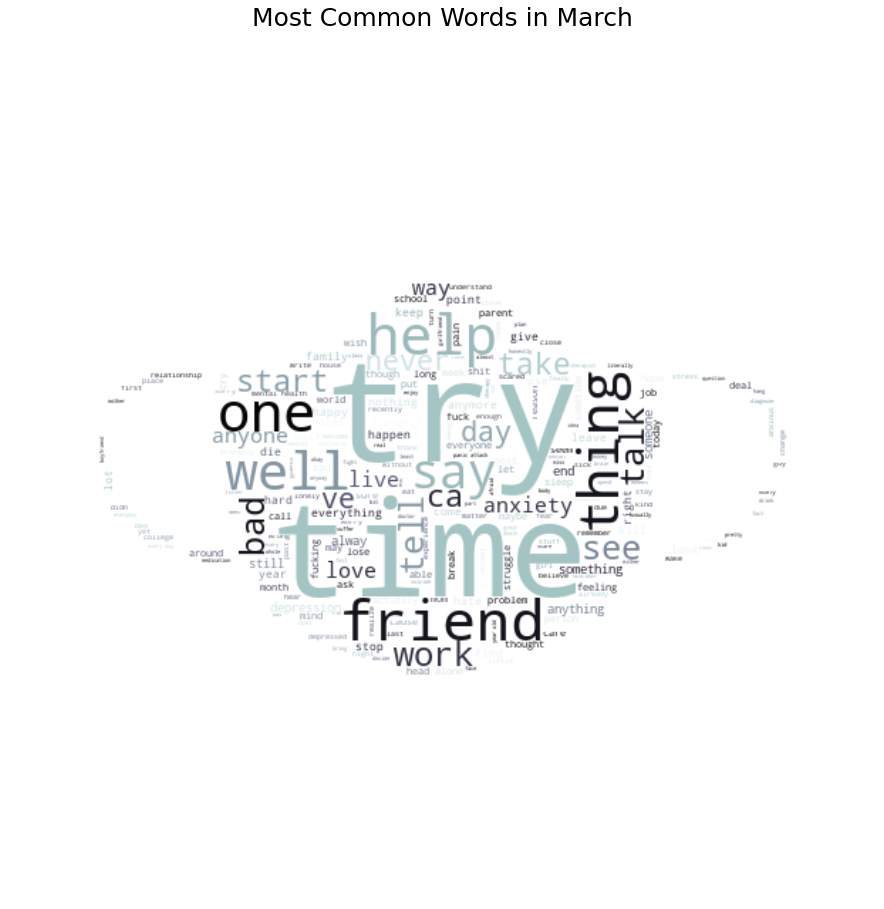

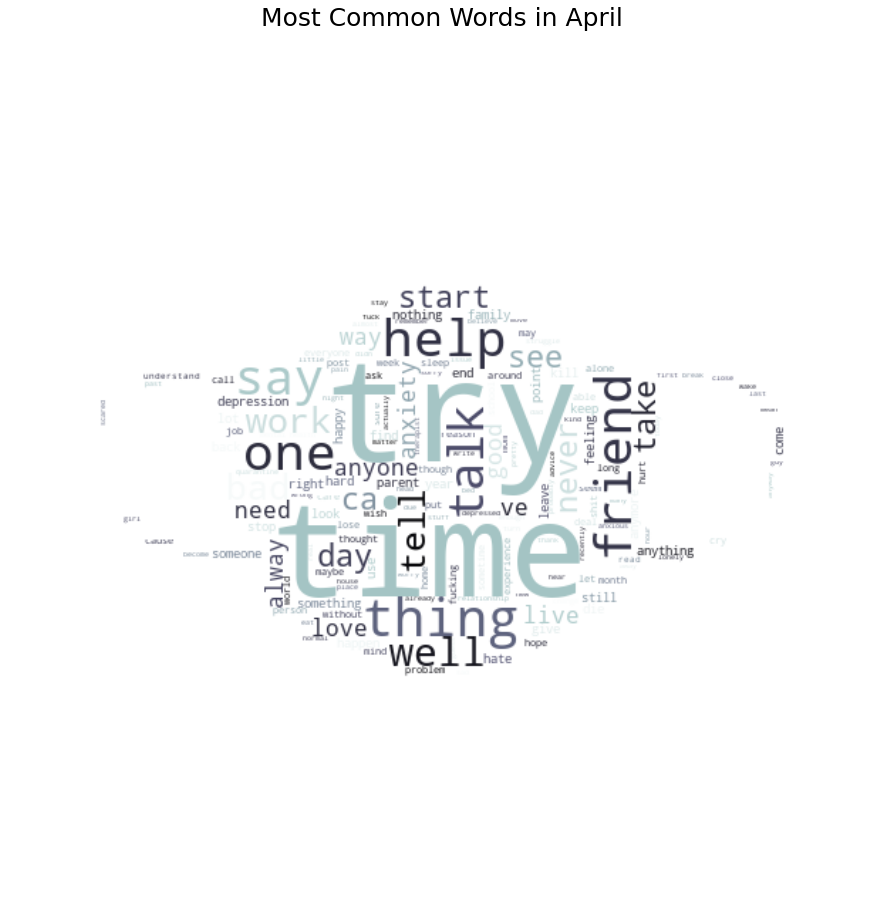

In [30]:
# wordcloud by month

months = {1: 'january', 2: 'february', 3: 'march', 4: 'april'}

for k, v in months.items():
    
    wordcloud(image = 'mask.jpg', data = df[df['date'].dt.month == k]['lemmatized'], color = 'bone', font = 100,
              fig = (24, 16), title = f'Most Common Words in {v.title()}', save_name = f'wc_{v}', background = 'white')